# 영화리뷰 텍스트 감성분석기

이번에는 글 속에 담긴 감성을 분석하는 모델을 구현해보겠습니다. 사람도 글에 담긴 뉘앙스를 파악하는게 쉽지 않은데 기계가 할 수 있다는게 너무 신기하네요.

다른 사람의 마음을 알고 싶다는 인간의 욕구는 어제오늘 일이 아니었죠. 특히 인터넷 상에 올라온 글들은 특정한 대상을 가지고 있는 경우가 많고, 그 대상을 향한 감정을 분석함으로써 효율적이고 많은 수의 대상에 대한 평가를 확보할 수 있게 되었습니다. 이러한 정보는 마케팅 등의 영역에서는 매우 귀중한 정보가 될 수 있겠죠.

이러한 정보를 얻기 위한 단계인 **감성분석**(*Sentiment Analysis*)은 어떠한 **대상**(*Target*)을 향한 **감정표현**(*Sentiment Expression*)이 필수적이며 이로부터 감정(emotion), 감성(sentiment), 태도(attitude), 입장(stance) 등을 분석한다.

분석은 총 3단계로 이루어지는데, **데이터 수집 -> 주관성 탐지 -> 주관의 정도**로 나누기 순서로 분류하는데, 주관의 정도를 나눌 때 **기계학습 기반 접근법**과 **감성사전 기반 접근법** 두 가지 형태로 접근할 수 있다.  기계학습은 라벨링이 되어있는 문서나 문장으로 학습한 모델을 사용하는 것이며 이 방식이 불가능할 경우 감성사전 기반 분석 방법을 사용하게 되는데, 감성사전 기반 분석은 미리 구성된 감성사전의 품질이 결과로 이어진다. 문제는 양질의 감성사전을 구축하는 일은 많은 시간과 비용이 들어가는 점, 분석 대상에 따라 점수가 달라질 수 있다는 점, 애매한 긍부정은 분석이 어렵다는 점 등의 단점이 있습니다.

그럼 대체 왜 텍스트 데이터일까요? 텍스트 데이터는 SNS등 인터넷 상에서 대량의 데이터를 쉽게 확보가 가능한데, 이 데이터들에는 **작성자의 주관**이 그대로 드러나 있고 **실시간 트랜드**를 빠르게 반영하는 특징이 있기 때문인데요. 문제는 텍스트는 구조가 희소하고 차원의 수가 크기 때문에 전통적인 지도학습으로는 좋은 성과를 내기 힘들었습니다. 그런데 최근에는 텍스트를 저차원의 벡터값으로 표현하는 **워드 임베딩**(*word embedding*)기법이 등장해서 **CNN**(*Convolutional Neural Network*)과 **LSTM**(*Long Short-Term Memory Network*) 등의 딥러닝 모델에 활용되고 있습니다.

## 1. 자료준비하기

### (1) 데이터 준비와 확인

이번에는 네이버 영화리뷰 감정분석기를 구현해보겠습니다. 그러기 위해서 네이버 영화의 댓글을 모아놓은 데이터셋을 다운받습니다.
  
\$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt  
\$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt

다운받은 데이터셋을 원하는 위치에 옮겨놓고 데이터를 확인해보겠습니다.

In [181]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/workplace/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/workplace/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()




,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


여러가지 ~~재미있는~~ 리뷰들을 확인할 수 있습니다.  
  
  
  
### (2) 텍스트 데이터를 숫자로 표현하기

컴퓨터는 단순히 0과 1만을 입력받습니다. 우리가 사용하는 텍스트 데이터도 사실은 숫자로 변환이 되어지는 겁니다. 그런데 이번에 우리가 해보고 싶은 것은 단순히 텍스트를 숫자로 일대일 매칭을 시키는 것이 아닌 **특정단어와 그 단어의 의미를 나타내는 백터**를 연결시켜 컴퓨터가 텍스트의 의미를 분류할 수 있게 하려는 겁니다.  
  
사람이 혼자서 모르는 단어를 찾을 때 사용하는 물건이 있죠. 바로 **사전**입니다. 그래서 처음에 시작할 일은 바로 컴퓨터가 사용할 수 있는 사전을 만들어주는 것입니다. 그러면 아까 다운받은 텍스트 자료를 가공하여 사전을 만들어보겠습니다. 사전을 만들 때에는 또한 몇가지 유의사항있는데요.

1. 중복된 데이터 제거
2. NaN 결측치 제거
3. 한국어 토크나이저로 토큰화
4. 불용어(*stopwords*) 제거
5. 사전(*word_to_index*) 구성
6. 텍스트 스트링을 사전 인덱스 스트링으로 변환
7. x_train, y_train, x_test, y_train

**사전의 질은 분류기의 성능과 직결**되는 문제이기 때문에 아무리 강조해도 지나치지 않습니다.  
위의 사항들은 사전의 질을 더 끌어올리는 것이 되겠죠.

In [182]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    x_train = []
    for sentence in train_data['document']:
        temp_x = tokenizer.morphs(sentence) # 토큰화
        temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
        x_train.append(temp_x)

    x_test = []
    for sentence in test_data['document']:
        temp_x = tokenizer.morphs(sentence) # 토큰화
        temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
        x_test.append(temp_x)

    words = np.concatenate(x_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    # 패딩, 시작점, 모르는 단어, 불용어 
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter] 
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    x_train = list(map(wordlist_to_indexlist, x_train))
    x_test = list(map(wordlist_to_indexlist, x_test))

    return x_train, np.array(list(train_data['label'])), x_test, np.array(list(test_data['label'])), word_to_index

x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)

In [183]:
index_to_word = {index:word for word, index in word_to_index.items()}

# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(x_train), len(x_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


### (3) 모델구성을 위한 데이터 분석 및 가공

이제 날 것의 텍스트 데이터를 사전으로 만들었습니다. 하지만 아직 사용하기에는 부족한데요, 그 이유는 컴퓨터가 사용하는 **데이터는 일정**해야 합니다. 하지만 저희가 만든 사전은 데이터의 길이가 들쭉날쭉해서 사용하기에 힘이 들겠죠. 사전을 만들 때 공통적인 약속이 있는데 몇가지 알아보겠습니다.

1. **<PAD\> = 패딩, <BOD\> = 문장의 시작, <UNK\> = 사전에 없는 단어(unknown)**은 보통 사전의 제일 앞에 넣어줍니다.
2. 사전의 벡터의 **최대 길이는 일정**해야하며 길이를 맞추기 위해 사용하는 것이 <PAD/>입니다.
3. 이런 식으로 만들어진 사전은 **(입력문장의 개수, 입력문장의 최대길이, 워드벡터의 차원수)**와 같은 모양을 띕니다.

이제 사전의 데이터들을 분석해보고 효율적인 방향으로 가공해보도록 하겠습니다.  
지금부터 저는 데이터셋 내 **문장 길이 분포를 파악**해보고, **적절한 최대 문장 길이를 지정**해준 후에, **패딩을 추가해서 데이터셋의 길이를 일정**하게 맞출겁니다.

In [184]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96938143432699
문장길이 최대 :  116
문장길이 표준편차 :  12.843571939469296
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


위의 데이터를 보면 전체문자의 100%가 포함되게 설정하지 않았는데요. 그 이유는 짧은 문장과 긴 문장이 있는데 몇 안되는 긴 문장을 위해서 **최대길이에 모든 것을 맞추는 것은 비효율적**이기 때문입니다.  
  
이제 <PAD\>를 넣어 길이를 맞출건데요. padding에 옵션을 넣어서 단어의 앞(pre)에 넣을 것인지 뒤(post)에 넣을 것인지를 결정할 수 있습니다. 저는 pre를 사용할 예정인데요. 그 이유는 뒤에 RNN알고리즘을 사용할 예정이기 때문입니다. **RNN알고리즘은 앞의 결과물을 다음 질문으로 가져가는 특징이 있습니다. 뒤의 결정은 앞의 내용을 포함하고 있기 때문에 데이터가 뒤로 갈수록 점점 더 중요해지는데요.** 그 때문에 빈 값인 <PAD\>를 중요한 부분인 뒷자리에 놓는 것보다 앞자리에 놓는 것이 상대적으로 더 효율적입니다.

In [185]:
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 41)


## 2. 모델 학습시키기

### (1) 모델구성 및 validation set 구성

이제 모델구성을 할 차례인데요. 오늘은 **Recurrent Neural Network**(*RNN*), **1-D Convolution Nueral Network**(*1-D CNN*), **GlobalMaxPoolingID() 레이어**를 사용해볼 예정입니다.

일단 데이터셋의 사이즈와 워드 벡터의 차원수를 설정해주도록 하겠습니다.

In [ ]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

#### \* Recurrent Neural Network(RNN)

RNN은 연속되는 질문이 들어올때 이전 대답을 기억하고 그 대답에 이어지는 추가 대답을 할 수 있는 알고리즘입니다. 이를 state machine이라고 하고 이러한 대화를 stateful하다고 합니다. 이러한 특징 덕분에 RNN 알고리즘은 **sequence** 형태의 데이터를 처리할 때 매우 효율적입니다. 


In [186]:
# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
# [[YOUR CODE]]
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, None, 200)         2000000   
_________________________________________________________________
lstm_14 (LSTM)               (None, 8)                 6688      
_________________________________________________________________
dense_42 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


#### \* 1-D Convolution Nueral Network(1-D CNN)

2-D CNN은 보통은 이미지 처리를 할 때 많이 사용하는데 한꺼번에 모든 이미지 데이터를 병렬처리방식으로 입력하는 방식으로 작동합니다. 1-D CNN은 7짜리 필터로 처음 7단어 이내의 특징들로 문장을 분류하게 되는데요. 병렬처리방식에 뛰어나기 때문에 학습속도가 빠르다는 장점이 있습니다.

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

#### \* GlobalMaxPoolingID

GlobalMaxPooingID()레이어만 단독으로 사용하는 방법인데요. 이 방식은 전체문장 중에 가장 중요한 단어의 특징으로 분류하는 방식입니다.

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

이 외에도 RNN과 1-D CNN을 섞어서 사용하는 방법, FeedForward Network(FFN) layer, Transformer layer 등 다양한 방법이 존재합니다.  
  
이제 데이터셋을 학습용과 검증용으로 나누겠습니다.

In [187]:
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


### (2) 모델 훈련하기

이제 모델을 학습시켜보겠습니다.

In [188]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 2  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs = epochs,
                    batch_size = 512,
                    validation_data = (x_val, y_val),
                    verbose = 1)

results = model.evaluate(x_test, y_test, verbose = 2)

print(results)

Epoch 1/2
266/266 [==============================] - 7s 27ms/step - loss: 0.4427 - accuracy: 0.8008 - val_loss: 0.3467 - val_accuracy: 0.8482
Epoch 2/2
266/266 [==============================] - 7s 27ms/step - loss: 0.3206 - accuracy: 0.8636 - val_loss: 0.3314 - val_accuracy: 0.8525
1537/1537 - 3s - loss: 0.3466 - accuracy: 0.8495
[0.3466266393661499, 0.8494822978973389]


그래도 결과가 썩 나쁘진 않네요. 목표점수에 거의 근접했습니다.

### (3) Loss, Accuracy 그래프 시각화

이제 훈련의 결과를 눈으로 확인해볼 차례입니다. 시각적으로 편하게 보기위해서 그래프화시킬건데요.
여태까지의 정보가 history에 담겨있으니 이 데이터를 바탕으로 plt를 사용하여 그래프를 그려보겠습니다.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


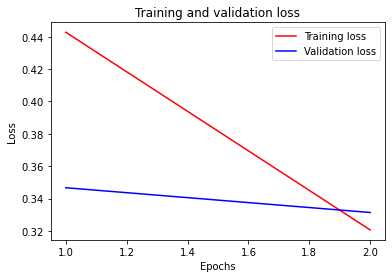

In [189]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'r', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


저같은 경우에 처음에는 epochs를 20으로 했었는데 이 그래프를 보니 2부터 **validation loss와 train loss가 역전**되는 것을 보고 2로 수정했습니다.

## 3. 모델성능 올리기

### (1) 학습된 Embedding 레이어 분석

이번에는 제가 만든것이 아닌 미리 학습되어진 Embedding layer를 사용해서 분류해 보겠습니다. 위에서 언급했듯이 텍스트 데이터를 다루는 작업은 **사전**이 많은 영향을 끼칩니다. 그래서 제가 방금 만든것이 아닌 다른 작업에서 사용되었던 잘 만들어진 사전을 이용하면 성능에 어느 정도 영향을 끼치는지 알아보겠습니다.

https://github.com/Kyubyong/wordvectors

해당 경로에서 한국어 Word2Vec을 다운받습니다.


In [190]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/workplace/aiffel/sentiment_classification/movie_review_word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

(10000, 200)


In [191]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([ 2.98118256e-02, -4.15369719e-02, -7.80596212e-02,  3.72916870e-02,
       -1.18182572e-02,  2.48203427e-02, -9.69849974e-02,  1.78452462e-01,
        4.46574017e-02, -2.31708866e-02, -6.43629953e-02, -4.48834971e-02,
        4.83314916e-02, -4.75084335e-02,  5.33426292e-02,  1.01025335e-01,
       -3.18291113e-02,  3.36804278e-02, -1.02125324e-01,  1.76689923e-02,
        1.08970487e-02,  1.08947128e-01, -5.53667471e-02, -7.00020790e-02,
       -3.58177125e-02,  6.88131899e-02, -1.22325066e-02,  4.06690426e-02,
       -3.60290371e-02,  3.23962122e-02,  9.09035355e-02,  2.42887493e-02,
        1.09379940e-01,  9.20009241e-03,  3.35835442e-02,  1.07577488e-01,
        1.83216222e-02,  2.03421891e-01,  3.64878774e-02, -2.64845490e-02,
       -1.64385624e-02, -1.26690924e-01, -7.95888901e-02, -3.50578316e-02,
        3.10619995e-02, -6.14832118e-02, -7.59239774e-03, -1.17499093e-02,
        1.24809612e-02,  1.30665600e-02, -2.38889921e-02,  5.73139600e-02,
       -8.73674154e-02, -

In [192]:
word_vectors.similar_by_word("사랑")

[('명작', 0.8578647375106812),
 ('재미있', 0.8561526536941528),
 ('걸작', 0.8429862260818481),
 ('최고', 0.836362898349762),
 ('만점', 0.8320773839950562),
 ('굿', 0.8286457061767578),
 ('펑펑', 0.8276242017745972),
 ('명화', 0.826191782951355),
 ('꼭', 0.8257870674133301),
 ('눈물', 0.8238916993141174)]

In [ ]:
이 것은 제가 만든 사전에서 사랑과 비슷한 단어를 찾는 메서드를 사용한 결과인데요. 참 엉뚱하네요.

### (2) 한국어 Word2Vec 임베딩 활용하여 성능개선

이제 다운받은 데이터셋으로 비교해보겠습니다.

In [193]:
# from gensim.models import KeyedVectors
from gensim.models import Word2Vec
word2vec_path = os.getenv('HOME')+'/workplace/aiffel/sentiment_classification/ko/ko.bin'
word2vec = Word2Vec.load(word2vec_path)
# word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['영화']
vector     

array([-1.7577837 , -1.0874279 ,  1.5300866 , -0.1115231 , -0.37980682,
        1.4828517 ,  1.3180419 ,  0.11094163,  0.7430535 , -0.45461136,
        0.58841336,  0.5763913 ,  1.210707  ,  1.3132795 , -0.86962503,
       -0.18507595, -0.47440064,  1.5100725 ,  1.0965794 ,  1.0600823 ,
       -0.27457932, -0.70003706,  2.3117511 ,  1.4944884 ,  0.25560892,
       -2.866659  , -0.28312334,  0.34263936, -0.67723423,  0.71714777,
        0.25549442,  0.71732044, -0.13262457,  0.01792452, -0.3184774 ,
        0.5271619 ,  0.7561084 , -2.1247065 ,  1.061429  , -0.21065854,
        0.6877343 , -1.4956383 ,  0.60346967, -2.6955893 ,  0.37694618,
       -1.0164185 ,  0.5430663 ,  0.1200121 , -2.6315718 ,  0.6216742 ,
        1.1583976 , -2.5385962 ,  1.326312  , -0.10284371, -0.0286147 ,
       -0.9132947 ,  0.7647564 ,  0.79202783, -1.8625957 , -0.7418395 ,
        0.5884277 , -0.9917992 , -0.62114453,  1.5367815 , -0.6628939 ,
        0.6712103 ,  0.12914915,  0.21228492,  0.9017655 , -0.25

In [194]:
word2vec.similar_by_word("사랑")

[('슬픔', 0.7216663360595703),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985676765442),
 ('기쁨', 0.6458414793014526),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937871932983),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206068992614746),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

약간 아리송한 단어들도 있지만 그래도 제법 **연관된 단어**들로 변한것을 확인할 수 있습니다.

### (3) 모델 학습시키기

In [196]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 200  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다.         

#### \* Recurrent Neural Network(RNN)

In [198]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, None, 200)         2000000   
_________________________________________________________________
lstm_15 (LSTM)               (None, 8)                 6688      
_________________________________________________________________
dense_44 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


#### \* 1-D Convolution Nueral Network(1-D CNN)

In [ ]:
from tensorflow.keras.initializers import Constant

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

#### \* GlobalMaxPoolingID

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

In [199]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 2  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs = epochs,
                    batch_size = 512,
                    validation_data = (x_val, y_val),
                    verbose = 1)

Epoch 1/2
266/266 [==============================] - 7s 27ms/step - loss: 0.4368 - accuracy: 0.8079 - val_loss: 0.3428 - val_accuracy: 0.8514
Epoch 2/2
266/266 [==============================] - 7s 26ms/step - loss: 0.3211 - accuracy: 0.8652 - val_loss: 0.3269 - val_accuracy: 0.8579


### (4) 테스트하기

In [200]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3414 - accuracy: 0.8527
[0.3413885831832886, 0.8526964783668518]


목표점수였던 85점을 간신히 넘겼네요.

## 4. 회고

모델별로 RNN이 85프로, CNN이 78프로, GlobalMaxPoolingID layer만 사용한 것이 83프로가 나왔네요.  
모델별 특징을 잘 알고 사용하는것이 효율적이라는 것을 느낄 수 있었습니다.

또한 이번 프로젝트로 하이퍼 파라미터를 적당히 조절하는 것이 중요하다는 점, 예를 들어 epochs를 무작정 올려봤자 큰 도움이 되지 않는다는 것을 배울수 있었습니다.  

그리고 뭐니뭐니해도 가장 큰 수확은 전혀 몰랐던 비전과 자연어의 차이를 어렴풋이나마 느낄수있었던 점이었던 것 같습니다.  